In [1]:
import sys, os, re; sys.path = (["../../src/", "../../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, Optional, List

import qubx
%qubxd

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.pandaz.utils import *

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, AsOhlcvSeries
from qubx.core.basics import Deal, Instrument, Order, Position, Signal
from qubx.utils.charting.lookinglass import LookingGlass
from qubx.core.utils import recognize_time, time_to_str

from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet, chart_signals, portfolio_metrics
from qubx.trackers.riskctrl import StopTakePositionTracker
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer, FixedLeverageSizer
from qubx.utils.misc import this_project_root


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# Issue 1

In [3]:
signals = pd.read_csv(this_project_root() / "tests/data/generated_signals.csv", index_col="timestamp", parse_dates=True)
print(signals.index[0], '>--<', signals.index[-1])
exchange, symbol = "BINANCE.UM", "BTCUSDT"

2023-08-13 17:23:33.720000 >--< 2024-04-30 22:30:00.030000


In [5]:
reader = CsvStorageDataReader(this_project_root() / "tests/data/csv")
ohlc = reader.read("BTCUSDT_ohlcv_M1", transform=AsPandasFrame())
assert (i1 := lookup.find_symbol(exchange, symbol)) is not None
S = pd.DataFrame( { exchange + ":" + symbol: {
            pd.Timestamp("2024-01-10 15:08:59.716000"): 1,
            pd.Timestamp("2024-01-10 15:10:52.679000"): 1,
            pd.Timestamp("2024-01-10 15:32:44.798000"): 1,
            pd.Timestamp("2024-01-10 15:59:55.303000"): 1,
            pd.Timestamp("2024-01-10 16:09:00.970000"): 1,
            pd.Timestamp("2024-01-10 16:12:34.233000"): 1,
            pd.Timestamp("2024-01-10 19:04:00.905000"): 1,
            pd.Timestamp("2024-01-10 19:44:37.785000"): 1,
            pd.Timestamp("2024-01-10 20:06:00.322000"): 1,
        }}
)

In [6]:
# S = signals['2023-08-27 14:00':'2023-08-29 14:30']
# S = signals['2024-02-26 00:00':'2024-02-27 00:00']
rep = simulate(
    {
        "liq_buy_bounces_c": [S, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "client")],
        "liq_buy_bounces_b": [S, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "broker")],
    },
    {"ohlc(1Min)": {symbol: ohlc}}, # type: ignore
    10000, [exchange + ":" + symbol],
    commissions="vip9_usdt",
    debug="DEBUG",  # type: ignore
    # start=S.index[0], stop=S.index[-1] + pd.Timedelta('5Min'),
    open_close_time_indent_secs=1,
    start=S.index[0] - pd.Timedelta("5Min"), # type: ignore
    stop=S.index[-1] + pd.Timedelta("5Min"), # type: ignore
)

  0%|          | 0/2 [00:00<?, ?it/s]

2024-01-10 15:03:59.716 [🐞] [simulator] :: Preparing simulated trading on BINANCE.UM for 10000 USDT...
2024-01-10 15:03:59.716 [ℹ️] SimulatedDataProvider.binance.um is initialized
2024-01-10 15:03:59.716 [🐞] SignalsProxy new parameters:
	set timeframe <- 1Min


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2024-01-10 15:03:59.716 [🐞] [SimulatedDataProvider] :: Using pre-generated signals:
 BINANCE.UM:BTCUSDT    9

2024-01-10 15:03:59.716 [🐞] [simulator] :: Setting default schedule: */1 * * * *
2024-01-10 15:03:59.716 [🐞] [simulator] :: Strategy didn't set warmup period for ohlc(1Min) so default 5Min will be used
2024-01-10 15:03:59.716 [ℹ️] SimulatedDataProvider ::: Simulation started at 2024-01-10 15:03:59.716000 :::
2024-01-10 15:03:59.716 [🐞]   [IteratedDataStreamsSlicer] :: Preloading initial data for ohlc.1Min 2024-01-10 15:03:59.716000 : 2024-01-10 20:06:00.322000 ...
2024-01-10 15:04:05.000 [🐞] [ProcessingManager] :: Invoking SignalsProxy on_fit
2024-01-10 15:04:05.000 [🐞] [ProcessingManager] :: SignalsProxy is fitted
2024-01-10 15:08:59.716 [🐞] [ClientSideRiskController(BINANCE.UM:FUTURE:BTCUSDT)] :: New signal: Target +0.022000 for SignalsProxy 45162.00 +1.000000 BINANCE.UM:FUTURE:BTCUSDT stop: 44936.2 take: 46291.1
2024-01-10 15:08:59.716 [🐞]   [TradingManager(BTCUSDT)] :: Send

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2024-01-10 15:03:59.716 [🐞] [SimulatedDataProvider] :: Using pre-generated signals:
 BINANCE.UM:BTCUSDT    9

2024-01-10 15:03:59.716 [🐞] [simulator] :: Setting default schedule: */1 * * * *
2024-01-10 15:03:59.716 [🐞] [simulator] :: Strategy didn't set warmup period for ohlc(1Min) so default 5Min will be used
2024-01-10 15:03:59.716 [ℹ️] SimulatedDataProvider ::: Simulation started at 2024-01-10 15:03:59.716000 :::
2024-01-10 15:03:59.716 [🐞]   [IteratedDataStreamsSlicer] :: Preloading initial data for ohlc.1Min 2024-01-10 15:03:59.716000 : 2024-01-10 20:06:00.322000 ...
2024-01-10 15:04:05.000 [🐞] [ProcessingManager] :: Invoking SignalsProxy on_fit
2024-01-10 15:04:05.000 [🐞] [ProcessingManager] :: SignalsProxy is fitted
2024-01-10 15:08:59.716 [🐞] [BrokerSideRiskController(BINANCE.UM:FUTURE:BTCUSDT)] :: New signal: Target +0.022000 for SignalsProxy 45162.00 +1.000000 BINANCE.UM:FUTURE:BTCUSDT stop: 44936.2 take: 46291.1
2024-01-10 15:08:59.716 [🐞]   [TradingManager(BTCUSDT)] :: Send

In [7]:
scols(rep[0].executions_log, rep[1].executions_log).fillna(' ')

,instrument_id,exchange_id,side,filled_qty,price,commissions,commissions_quoted,instrument_id,exchange_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,,,,,,,,,
2024-01-10 15:08:59.716,BTCUSDT,BINANCE.UM,buy,0.022,45162.05,0.168906,USDT,BTCUSDT,BINANCE.UM,buy,0.022,45162.05,0.168906,USDT
2024-01-10 17:44:36.000,BTCUSDT,BINANCE.UM,sell,-0.022,46327.55,0.173265,USDT,BTCUSDT,BINANCE.UM,sell,-0.022,46291.10,0.000000,USDT
2024-01-10 19:04:00.905,BTCUSDT,BINANCE.UM,buy,0.021,46493.95,0.165983,USDT,BTCUSDT,BINANCE.UM,buy,0.021,46493.95,0.165983,USDT
2024-01-10 19:08:36.000,BTCUSDT,BINANCE.UM,sell,-0.021,46171.95,0.164834,USDT,BTCUSDT,BINANCE.UM,sell,-0.021,46261.40,0.165153,USDT
2024-01-10 19:44:37.785,BTCUSDT,BINANCE.UM,buy,0.021,46255.05,0.165131,USDT,BTCUSDT,BINANCE.UM,buy,0.021,46255.05,0.165131,USDT


In [8]:
rep[0].signals_log

,instrument_id,exchange_id,signal,target_position,reference_price,price,take,stop,group,comment,service
timestamp,,,,,,,,,,,
2024-01-10 15:08:59.716,BTCUSDT,BINANCE.UM,1,0.022,45162.0,None,46291.1,44936.2,SignalsProxy,,False
2024-01-10 15:10:52.679,BTCUSDT,BINANCE.UM,1,0.022,45287.8,None,46420.0,45061.4,SignalsProxy,,False
2024-01-10 15:32:44.798,BTCUSDT,BINANCE.UM,1,0.022,45345.0,None,46478.6,45118.3,SignalsProxy,,False
2024-01-10 15:59:55.303,BTCUSDT,BINANCE.UM,1,0.021,45569.0,None,46708.2,45341.2,SignalsProxy,,False
2024-01-10 16:09:00.970,BTCUSDT,BINANCE.UM,1,0.022,45370.0,None,46504.3,45143.2,SignalsProxy,,False
2024-01-10 16:12:34.233,BTCUSDT,BINANCE.UM,1,0.022,45395.8,None,46530.7,45168.8,SignalsProxy,,False
2024-01-10 17:44:36.000,BTCUSDT,BINANCE.UM,0,0.000,NaN,None,NaN,NaN,Risk Manager,Take triggered,False
2024-01-10 19:04:00.905,BTCUSDT,BINANCE.UM,1,0.021,46493.9,None,47656.3,46261.4,SignalsProxy,,False
2024-01-10 19:08:36.000,BTCUSDT,BINANCE.UM,0,0.000,NaN,None,NaN,NaN,Risk Manager,Stop triggered,False


In [44]:
rep[1].signals_log

,instrument_id,exchange_id,signal,target_position,reference_price,price,take,stop,group,comment,service
timestamp,,,,,,,,,,,
2024-01-10 15:08:59.716,BTCUSDT,BINANCE.UM,1,0.022,45162.0,NaN,46291.1,44936.2,SignalsProxy,,False
2024-01-10 15:10:52.679,BTCUSDT,BINANCE.UM,1,0.022,45287.8,NaN,46420.0,45061.4,SignalsProxy,,False
2024-01-10 15:32:44.798,BTCUSDT,BINANCE.UM,1,0.022,45345.0,NaN,46478.6,45118.3,SignalsProxy,,False
2024-01-10 15:59:55.303,BTCUSDT,BINANCE.UM,1,0.021,45569.0,NaN,46708.2,45341.2,SignalsProxy,,False
2024-01-10 16:09:00.970,BTCUSDT,BINANCE.UM,1,0.022,45370.0,NaN,46504.3,45143.2,SignalsProxy,,False
2024-01-10 16:12:34.233,BTCUSDT,BINANCE.UM,1,0.022,45395.8,NaN,46530.7,45168.8,SignalsProxy,,False
2024-01-10 17:44:36.000,BTCUSDT,BINANCE.UM,0,0.000,NaN,46291.1,NaN,NaN,Risk Manager,Take triggered,True
2024-01-10 19:04:00.905,BTCUSDT,BINANCE.UM,1,0.021,46493.9,NaN,47656.3,46261.4,SignalsProxy,,False
2024-01-10 19:08:36.000,BTCUSDT,BINANCE.UM,0,0.000,NaN,46261.4,NaN,NaN,Risk Manager,Stop triggered,True


In [45]:
chart_signals(rep[0], symbol, ohlc, '1Min',  show_signals=True, height=500)

In [46]:
chart_signals(rep[1], symbol, ohlc, '1Min',  show_signals=True, height=500)

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,liq_buy_bounces_c,21.634031,1.200730,0.0,1.934021,0.090494,9.074084,0.0,0.0,1.0,0.0,0.0,0.216340,0.838119,5.0
1,liq_buy_bounces_b,22.883527,1.303189,0.0,2.331296,0.071768,7.195953,0.0,0.0,1.0,0.0,0.0,0.228835,0.665173,5.0


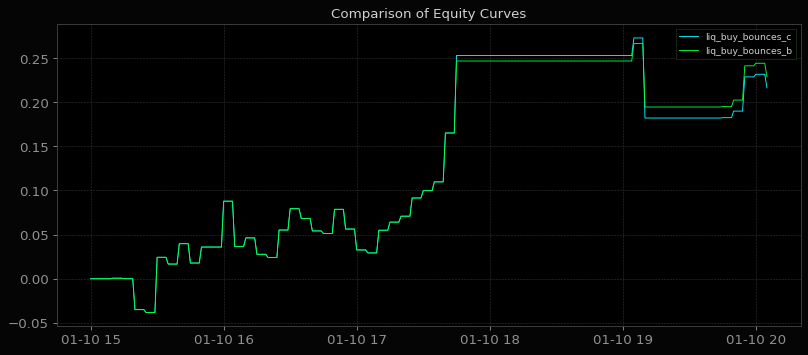

In [48]:
tearsheet(rep)

In [47]:
mtrx0 = portfolio_metrics(rep[0].portfolio_log, rep[0].executions_log, rep[1].capital, account_transactions=False, commission_factor=1)
mtrx1 = portfolio_metrics(rep[1].portfolio_log, rep[1].executions_log, rep[1].capital, account_transactions=False, commission_factor=1)
mtrx0['gain'], mtrx1['gain']

(22.4721499999996, 23.54869999999937)

# Issue 2

In [29]:
%load_ext autoreload
%autoreload 2

from qubx.trackers.riskctrl import StopTakePositionTracker
from qubx.trackers.sizers import FixedLeverageSizer

qdb = MultiQdbConnector('nebula')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-01-10 20:06:55.000 [🐞] Connected to QuestDB at nebula:8812


In [30]:
signals = pd.read_csv(this_project_root() / "tests/data/signals_issue.csv", index_col="timestamp", parse_dates=True)
signals

,BTCUSDT
timestamp,
2024-01-30 12:29:59.036,1
2024-01-30 13:16:35.910,1
2024-01-30 23:15:40.180,1
2024-01-30 23:29:00.270,1
2024-01-31 10:50:31.171,1
2024-01-31 20:02:58.573,1
2024-01-31 20:07:46.123,1
2024-01-31 21:25:58.912,1


In [ ]:
rep = simulate(
    { 
        "liq_buy_bounces_broker": [signals, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "broker")], 
        "liq_buy_bounces_client": [signals, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "client")], 
    },
    {"ohlc(1Min)": qdb}, 10000, ["BINANCE.UM:BTCUSDT"], "vip9_usdt", 
    "2024-01-29", "2024-05-01", debug='DEBUG'
)

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,liq_buy_bounces_broker,-2.142249,-0.025730,-0.908984,-0.172214,0.213998,21.403123,-1.769982,-16.179801,0.866667,0.015384,20.657307,-0.007068,1.845549,12.0
1,liq_buy_bounces_client,-6.934955,-0.080941,-2.867011,-0.323526,0.241785,24.182201,-4.912265,-43.326317,0.629959,0.134653,22.926860,-0.023043,2.015255,12.0


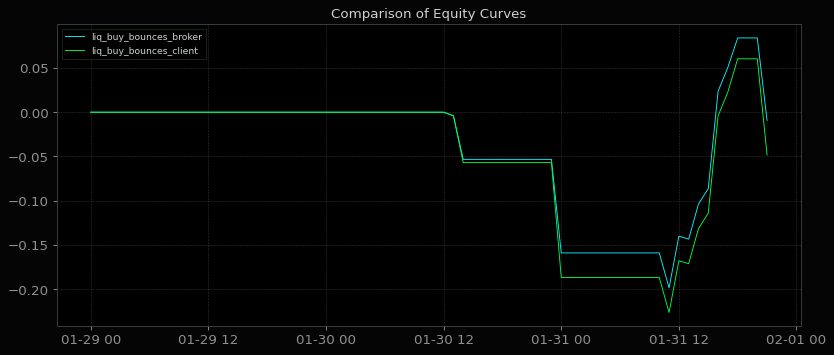

In [37]:
tearsheet(rep)

In [34]:
ohlc = {"BTCUSDT": qdb.read("BINANCE.UM:BTCUSDT", "2024-01-30", "2024-02-01", transform=AsPandasFrame())}

In [ ]:
chart_signals(rep[0], 'BTCUSDT', ohlc, '1Min',  show_signals=True)